In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import json
from environment import Environment
from logging_config import setup_logging
import logging
from utils import findUE, BPRCostFunction, findSO   
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "no-latex"])


In [28]:
import pandas as pd
import random
import numpy as np

In [29]:
params = None
with open("params.json") as f:
    params = json.load(f)
if not params:
    raise Exception("No parameters found!")
env1 = Environment(params) # area with PoA ~1.1
params['env_params']['PoA'] = 1.3
env2 = Environment(params) # area with PoA ~1.3
envs = [env1,env2]

#DEBUG: ENV 1, Q_env: 29
#DEBUG: real_tSO(before clipping)=[15.94173462 17.2414469   9.42714678], hat_T=14.060497390092568
#DEBUG: real_tSO=[15.94173462 17.2414469   9.42714678], Inequities=[np.float64(1.8812372277596197), np.float64(3.1809495086571786), np.float64(-4.633350606371312)]
[ENV 1], PoA=1.185, routes=3, Q_env=29, Inequities=0.14, q_env=0.783, tUE=16.663, mean_SO_time=14.203, mean_inequity=-0.231, avg_inequity=0.000, tSO=[np.float64(15.941734617852187), np.float64(17.241446898749746), np.float64(9.427146783721255)]
#DEBUG: ENV 2, Q_env: 41
#DEBUG: real_tSO(before clipping)=[11.1200267   0.         64.88305587], hat_T=0.0
#DEBUG: real_tSO=[11.1200267   0.         64.88305587], Inequities=[np.float64(11.120026695746976), np.float64(0.0), np.float64(64.88305586943234)]
[ENV 2], PoA=inf, routes=3, Q_env=41, Inequities=25.33, q_env=1.107, tUE=32.442, mean_SO_time=25.334, mean_inequity=0.000, avg_inequity=0.000, tSO=[np.float64(11.120026695746976), np.float64(0.0), np.float64(64.8

/var/folders/w4/xs9m4t1j28598sp65xft3k1h0000gn/T/ipykernel_96494/1871523358.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  PoA = tUE / hat_T
/opt/anaconda3/envs/ox/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/envs/ox/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/envs/ox/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/opt/anaconda3/envs/ox/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anac

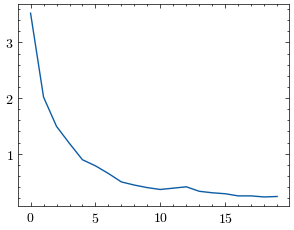

In [31]:
Q = params["env_params"]["Q"]  # total flow
choices = list(range(params["env_params"]["destinations"])) + [
    -1
]  # possible destinations + opt-out option
num_choices = len(choices)

# dataframe drivers and results
df = pd.DataFrame(index=range(Q))
df["I"] = np.random.normal(0, 10e-9, size=len(df))  # start with infidesimal noise for I


def day(df, d, params):
    # singe day

    df["choice"] = np.random.choice(choices, size=len(df))  # make random choices
    df["t"] = 0

    # to do check if newcomers equalize as well
    if d < params["env_params"]["fresh_after"]:
        df["choice"] = df.apply(
            lambda x: (
                x["choice"] if x.name > params["env_params"]["fresh_share"] else 0
            ),
            axis=1,
        )

    # for two environments
    # print("#DEBUG: number of agents", len(df))
    for i, env in enumerate(envs):
        # print(f"--- ENV {i+1} ---")
        k = len(env.routes)

        df["this_env"] = df.apply(lambda x: 1 if x.choice == i else 0, axis=1)
        df.loc[df["this_env"] == 1, "I_rank"] = df.loc[df["this_env"] == 1, "I"].rank(ascending=False).astype(int)  # prioritize higher I
        Q_env = len(df[df["this_env"] == 1])  # flow via env
        print(f"#DEBUG: ENV {i+1}, Q_env: {Q_env}")
        q_env = (
            params["env_params"]["congestion"] * Q_env / (Q / num_choices)
        )  # normalized for BPRs
        X, _ = findUE(q_env, env.routes)  # solve UE
        tUE = env.routes[0](X[0])  # UE time
        X, T = findSO(q_env, env.routes)  # SO flows and total travel time
        hat_T = T/ q_env  # predicted SO time per unit of flow
        tSO = [env.routes[j](X[j]) for j in range(k)]  # calc SO travel times on routes
        avg_inequity = sum([tSO[j]*X[j] for j in range(k)])/q_env - hat_T
        PoA = tUE / hat_T
        # calc realization of travel time (normal for imperfect prediction, 1e-5 for disruptions)
        p_disruption = params["env_params"]["p_disruption"]
        real_tSO = (
            tSO
            * np.random.normal(1, params["env_params"]["noise"], size=k)
            * np.random.choice([1, 10], p=[1 - p_disruption, p_disruption], size=k)
        )
        print(f"#DEBUG: real_tSO(before clipping)={real_tSO}, hat_T={hat_T}")
        Inequities = [
            ((real_tSO[j] - hat_T)) for j in range(k)
        ]  # calc inequity components

        print(f"#DEBUG: real_tSO={real_tSO}, Inequities={Inequities}")
        # 1. Sort routes from fastest to slowest
        route_order = np.array(tSO).argsort()
        
        flow_sum = X.sum()
        exact_count = (X[route_order] / flow_sum) * Q_env 
        counts = np.ceil(exact_count).astype(int)
            
        splits = np.cumsum(counts)

        ranks = df.loc[df["this_env"] == 1, "I_rank"].values - 1
        assigned_bins = np.searchsorted(splits, ranks, side='right')
        assigned_bins = np.clip(assigned_bins, 0, k-1)
        
        df.loc[df["this_env"] == 1, "route"] = route_order[assigned_bins]

        inequity_map = {route_idx: Inequities[route_idx] for route_idx in range(k)}
        df.loc[df["this_env"] == 1, "inequity today"] = df.loc[df["this_env"] == 1, "route"].map(inequity_map)

        df.loc[df["this_env"] == 1, "I"] += df.loc[df["this_env"] == 1, "inequity today"]
        print(
            ", ".join([f"[ENV {i+1}]",
            f"PoA={PoA:.3f}",
            f"routes={k}",
            f"Q_env={Q_env:.0f}",
            f"Inequities={np.mean(Inequities):.2f}",
            f"q_env={q_env:.3f}",
            f"tUE={tUE:.3f}",
            f"mean_SO_time={np.mean(tSO):.3f}",
            f"mean_inequity={df.loc[df['this_env'] == 1, 'inequity today'].mean():.3f}",
            f"avg_inequity={avg_inequity:.3f}",
            f"tSO={tSO}"])
        )
    return df


l = list()
for d in range(20):
    df = day(df, d, params)
    print(f"--- Day {d+1} completed ---")
    l.append(np.mean(df["I"]**2)/(d+1)) 
plt.plot(l)